# Group Recommender Systems - Tutorial 2 (Lab 2)


In this tutorial, we will see implement a pipeline for offline evaluation of Group Recommender Systems. After completing this tutorial, you will be able to: 
- Create synthetic groups with different sizes and internal similarities.
- Implement basic strategies for aggregating group members' predicted ratings and provide group recommendations.
- Evaluate the performance of the group recommender systems, using different a coupled or a decoupled evaluation protocol.


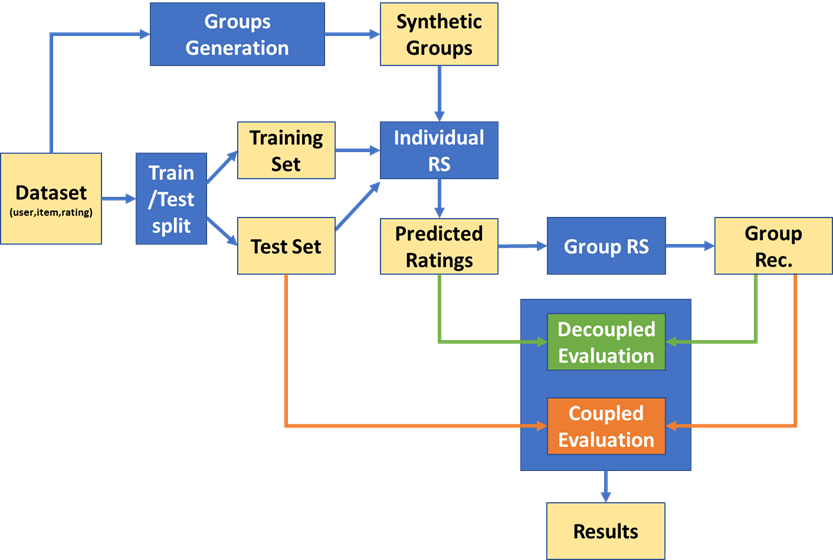

#### Summary [TO UPDATE]

1. Dataset
2. Preprocessing
3. Synthetic Groups Generation
4. Train/Test split
5. Individual RS training and generating predicted ratings
6. Aggregation strategies: generating group recommendations
7. Evaluation
    1. Coupled Evaluation
    2. Decoupled Evaluation

#### 1. Dataset


We will use the preprocessed dataset provided in the first lab, under the folder *preprocessed_dataset*. The dataset has been obtained from the 
[Movielens latest small](https://www.kaggle.com/grouplens/movielens-latest-small) dataset (providing user's ratings) and the [Wikipedia Movie Plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) dataset (providing movies' information). Check the notebook **Dataset Preprocessing** in the Lab 1 for details on how the datasets have been preprocessed and merged.

The dataset contains two CSV files, following  the structure of the Movielens dataset:
1. ratings.csv: contains the information about the feedback of the users for the movies. Each row contains the id of a user,the id of a movie, and the rating that the user gave to the movie. It also contains the timestamp, but we will not use it in this tutorial.
2. movies.csv: contains the information about the movies.


We start using the [pandas](https://pandas.pydata.org/) library to read the content of the CSV files and use it, as we did in the Lab 1.


In [294]:
import pandas as pd


In [295]:
ratings_df = pd.read_csv("XWines_Full_21M_ratings.csv") 
display(ratings_df.head(10))

,RatingID,UserID,WineID,Vintage,Rating,Date
0,1,1604441,136103,1950,4.0,2019-10-14 11:20:52
1,2,1291483,136103,1950,5.0,2019-11-28 03:36:33
2,3,1070605,104036,1950,5.0,2017-12-28 10:15:55
3,4,1080181,144864,1950,5.0,2016-06-23 02:16:22
4,5,1834379,111430,1950,5.0,2021-05-16 17:58:14
5,6,1995440,157985,1950,4.0,2016-01-06 22:14:14
6,7,1166181,101794,1950,5.0,2018-04-15 12:04:46
7,8,1839846,136103,1950,5.0,2020-07-18 15:41:19
8,9,1693747,136103,1950,1.0,2018-11-23 01:48:57
9,10,1478537,135897,1950,4.0,2015-05-04 19:52:09


In [296]:
ratings_df = ratings_df.drop(columns=['Vintage', 'Date'])
display(ratings_df.head(10))

,RatingID,UserID,WineID,Rating
0,1,1604441,136103,4.0
1,2,1291483,136103,5.0
2,3,1070605,104036,5.0
3,4,1080181,144864,5.0
4,5,1834379,111430,5.0
5,6,1995440,157985,4.0
6,7,1166181,101794,5.0
7,8,1839846,136103,5.0
8,9,1693747,136103,1.0
9,10,1478537,135897,4.0


In [297]:
wine_df = pd.read_csv('XWines_Full_100K_wines.csv', index_col="WineID")
display(wine_df.head(5))
print(wine_df.columns)

,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
WineID,,,,,,,,,,,,,,,,
100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200..."
100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
100004,Virtus Moscato,White,Varietal/100%,['Muscat/Moscato'],['Sweet Dessert'],12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10003,Monte Paschoal,http://www.montepaschoal.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."


Index(['WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'ABV', 'Body',
       'Acidity', 'Code', 'Country', 'RegionID', 'RegionName', 'WineryID',
       'WineryName', 'Website', 'Vintages'],
      dtype='object')


#### 2. Preprocessing


To generate synthetic groups we need to be able to evaluate similarities between users. As we only have the information about ratings, we will use this. Hence, we want to focus on users for which we can compute this similarity, requiring a minimum amount of rated WineIDs (and discarding the remaining users). At the same time, we want to focus on WineIDs rated by a certain number of users. In this pre-processing step, we will filter out users and WineIDs not having enough ratings. 

In [298]:
# Check number of ratings per WineID
rating_per_WineID_df = ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_WineID_df)

# Check number of ratings per user
rating_per_user_df = ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_user_df)

,RatingID,UserID,Rating
WineID,,,
155289,27415,27415,27415
179010,23626,23626,23626
179011,21216,21216,21216
111391,20913,20913,20913
167418,20817,20817,20817
...,...,...,...
200628,5,5,5
200629,5,5,5
200630,5,5,5


,RatingID,WineID,Rating
UserID,,,
1084433,2986,2986,2986
1034989,2979,2979,2979
1070878,2613,2613,2613
1048267,2597,2597,2597
1160536,2392,2392,2392
...,...,...,...
1709634,5,5,5
1709635,5,5,5
1709639,5,5,5


In [299]:
min_ratings_per_WineID = 1000
min_ratings_per_user = 200

In [300]:
# select WineIDs with the desidered number of ratings
selected_WineIDs = list(rating_per_WineID_df.loc[rating_per_WineID_df['Rating'] >= min_ratings_per_WineID].reset_index()['WineID'])
display(ratings_df.shape)
selected_ratings_df = ratings_df.loc[ratings_df['WineID'].isin(selected_WineIDs)]
display(selected_ratings_df.shape)

# Check number of ratings per WineID
rating_per_WineID_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_WineID_df)

# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_user_df)

(21013536, 4)

(8630733, 4)

,RatingID,UserID,Rating
WineID,,,
155289,27415,27415,27415
179010,23626,23626,23626
179011,21216,21216,21216
111391,20913,20913,20913
167418,20817,20817,20817
...,...,...,...
162823,1000,1000,1000
167821,1000,1000,1000
111986,1000,1000,1000


,RatingID,WineID,Rating
UserID,,,
1070878,775,775,775
1048267,719,719,719
1006657,629,629,629
1064787,623,623,623
1863413,619,619,619
...,...,...,...
1986273,1,1,1
1986276,1,1,1
1986297,1,1,1


In [301]:
# select users with the desidered number of ratings
selected_users = list(rating_per_user_df.loc[rating_per_user_df['Rating'] >= min_ratings_per_user].reset_index()['UserID'])
display(selected_ratings_df.shape)
selected_ratings_df = selected_ratings_df.loc[ratings_df['UserID'].isin(selected_users)]
display(selected_ratings_df.shape)

# Check number of ratings per WineID
rating_per_WineID_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_WineID_df)

# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_user_df)

(8630733, 4)

(202468, 4)

,RatingID,UserID,Rating
WineID,,,
155290,412,412,412
111391,391,391,391
155289,355,355,355
135826,336,336,336
162497,320,320,320
...,...,...,...
136496,1,1,1
167768,1,1,1
106542,1,1,1


,RatingID,WineID,Rating
UserID,,,
1070878,775,775,775
1048267,719,719,719
1006657,629,629,629
1064787,623,623,623
1863413,619,619,619
...,...,...,...
1097442,200,200,200
1112901,200,200,200
1365762,200,200,200


#### 3. Synthetic groups generation



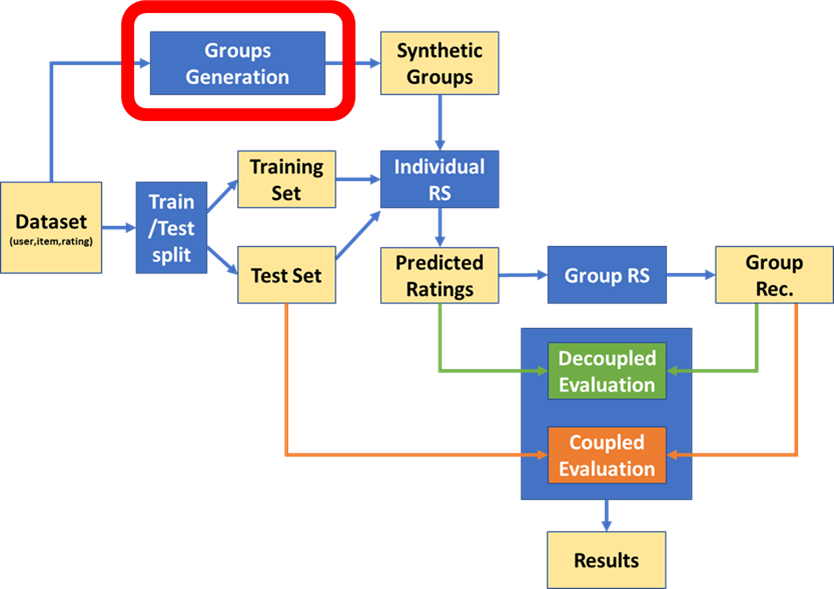


- Which types of groups will we generate? 
- Which sizes we want to evaluate?
- Similarity metric?
- How many groups?

We need to generate groups using the users from the dataset. As we don't have any information for this, we can only use the provided ratings. Two reasonable criteria to use in this case are:
1. Size: we can generate groups of different sizes and compare the performances of our strategies for different group sizes.
2. Similarity: we can generate easier and more difficult groups considering the internal similarity of the preferences.


#### 3.1 Similarity metric

In this example, we use the pearson correlation. This is often used in these types of evaluations. We assume two users are similar if their "rating patterns" are similar. This may not have sense in all cases, and the choice of the similarity metric needs to be motivated for the specific dataset.

In [302]:
# computing pearson similarity between each pair of users

import numpy as np

ratings_df = selected_ratings_df

user_matrix = ratings_df.pivot_table(columns='WineID', index='UserID', values='Rating')

user_id_set = set(ratings_df['UserID'])
user_id_indexes = user_matrix.index.values
display(type(user_id_indexes))
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)

display(user_matrix)
display(sim_matrix)

numpy.ndarray

WineID,100001,100006,100009,100010,100011,100012,100014,100021,100024,100026,...,193576,193577,193578,193579,193580,193581,193582,193583,193584,193585
UserID,,,,,,,,,,,,,,,,,,,,,
1000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000010,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000025,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000049,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0
1978784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[ 1.        ,  0.06074648,  0.06345183, ...,  0.02634737,
        -0.0198144 ,  0.10362233],
       [ 0.06074648,  1.        ,  0.17047188, ...,  0.0690307 ,
         0.09064869,  0.11906332],
       [ 0.06345183,  0.17047188,  1.        , ...,  0.09610352,
         0.10812832,  0.12340924],
       ...,
       [ 0.02634737,  0.0690307 ,  0.09610352, ...,  1.        ,
         0.10515132, -0.00215061],
       [-0.0198144 ,  0.09064869,  0.10812832, ...,  0.10515132,
         1.        , -0.01104065],
       [ 0.10362233,  0.11906332,  0.12340924, ..., -0.00215061,
        -0.01104065,  1.        ]])

Text(0.5, 0, "Pearson's Correlation Coeficient")

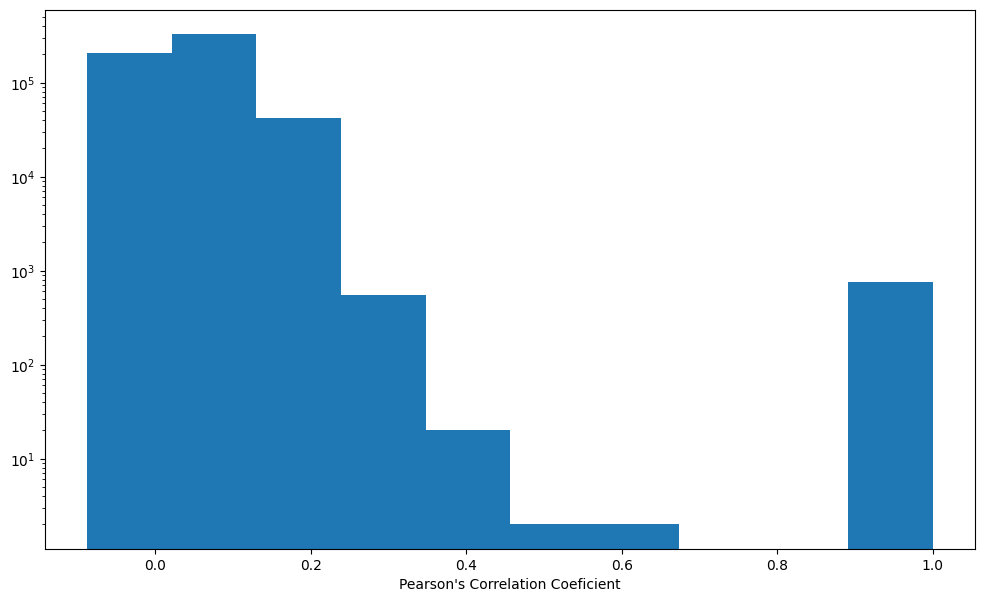

In [303]:
# visualizing similarity distributions

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")

#### 3.2 Group Generation

We focus here on types of groups defined on the basis of the internal similarity between the group member's preferences. The code below generates:
- types: similar, random, divergent
- sizes: 2 to 8 members per group
- number of group: 20 for each type and size combination

In [304]:
from importlib import reload

import groups_generators as groups_gen_utils
reload(groups_gen_utils)
import groups_generators as groups_gen_utils

group_sizes_to_create = [2,4,8] 
#group_sizes_to_create = [2, 3, 4, 5, 6, 7, 8]
group_similarity_to_create = [groups_gen_utils.GroupsGenerator.RANDOM]
group_number = 20

group_list = list()
for group_to_create in group_similarity_to_create:
    grpGenerator = groups_gen_utils.GroupsGenerator.getGroupsGenerator(group_to_create)
    current_group_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)
    group_list = group_list + current_group_list

groups_df = pd.DataFrame.from_records(group_list)
group_dict = dict()
for group_id, group in zip(range(len(group_list)), group_list):
    group_dict[group_id] = group

# display(group_list)
    
display(groups_df)

20
40
60


,group_size,group_similarity,group_members,avg_similarity
0,2,random,"[1193559, 1165093]",-0.001625
1,2,random,"[1126116, 1134628]",-0.030962
2,2,random,"[1141987, 1218032]",0.022187
3,2,random,"[1008305, 1208148]",0.164701
4,2,random,"[2030179, 1009797]",0.101979
5,2,random,"[1000413, 1230111]",-0.018386
6,2,random,"[1175256, 1218151]",0.045484
7,2,random,"[1034336, 1089420]",-0.011845
8,2,random,"[1447973, 1037801]",0.017893
9,2,random,"[1129534, 1190604]",0.111170


It is useful to verify the groups we created. In the code below we compare the avereage internal similarity for all the types of groups we created

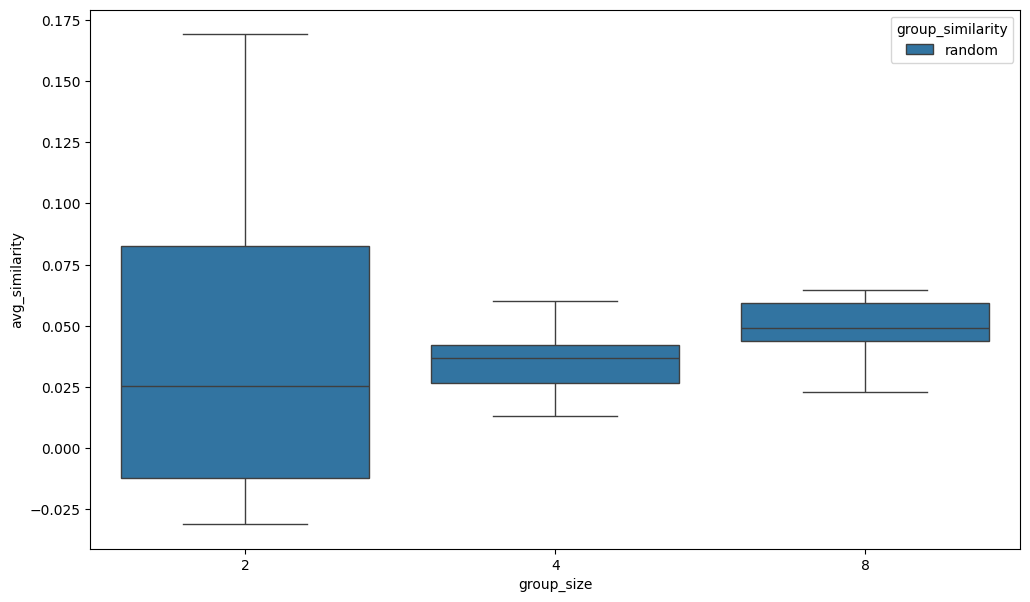

In [305]:
# Visualizing similarities for each type of group we created

import seaborn as sns


plt.rcParams["figure.figsize"] = (12,7)
sns.boxplot(x = groups_df['group_size'],
            y = groups_df['avg_similarity'],
            hue = groups_df['group_similarity'])
import matplotlib.pyplot as plt

#### 4. Train/Test split


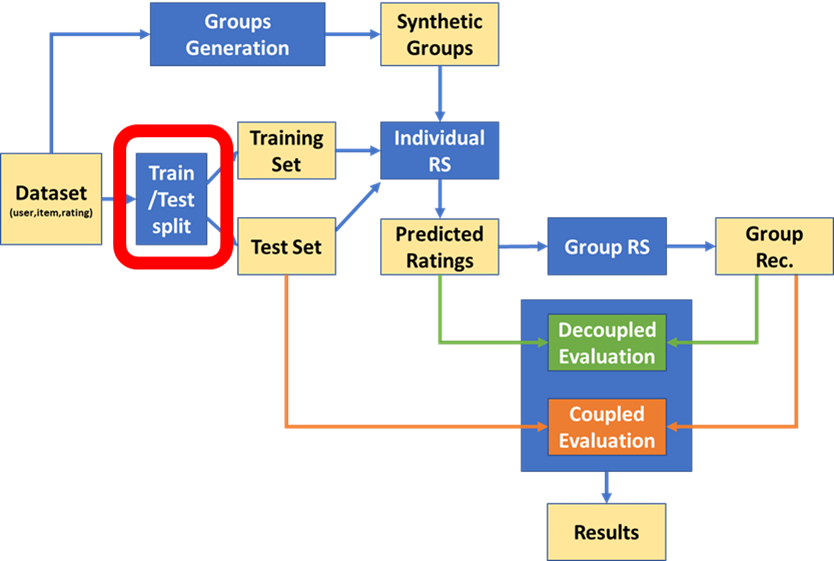

- Which strategy?
- Stratified split?
  
The choice of the criteria for splitting should be carefully defined on the basis of the problem we have, as well as the computational constraints. In this example, due to time constraints, we use a Hold-out (80-20 split) stratified by user. This ensures to have 80% of evaluations in the training set and 20% in the test set for each user. Different methodologies could be applied, and this choice needs to be properly motivated.

In [306]:
ratings_df =ratings_df.rename(columns={
    'RatingID': 'ratingId',  # Fixed typo
    'UserID': 'user',
    'WineID': 'item',
    'Vintage': 'vintage',
    'Rating': 'rating',
    'Date': 'date'
})

In [307]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

display(ratings_df.shape)
WineIDs = set(ratings_df["item"].tolist())
users = set(ratings_df["user"].tolist())

display(len(WineIDs))
display(len(users))

train_df, test_df = train_test_split(ratings_df, test_size=0.2, stratify=ratings_df[["user"]])

display(train_df.shape)
display(train_df.head(5))
display(test_df.shape)
display(test_df.head(5))

(202468, 4)

3739

758

(161974, 4)

,ratingId,user,item,rating
8491745,8491746,1223802,162559,4.0
12134752,12134753,1164660,101693,4.5
1008715,1008716,1158810,111487,4.0
9788022,9788023,1083419,167490,4.5
651556,651557,1251930,135843,4.5


(40494, 4)

,ratingId,user,item,rating
1007835,1007836,1367299,135838,4.0
5204669,5204670,1008661,136301,4.0
2343225,2343226,1084059,100029,4.0
6045022,6045023,1212264,179035,3.0
15449234,15449235,1735467,179565,3.5


#### 5. Individual RS training and generating predicted ratings.

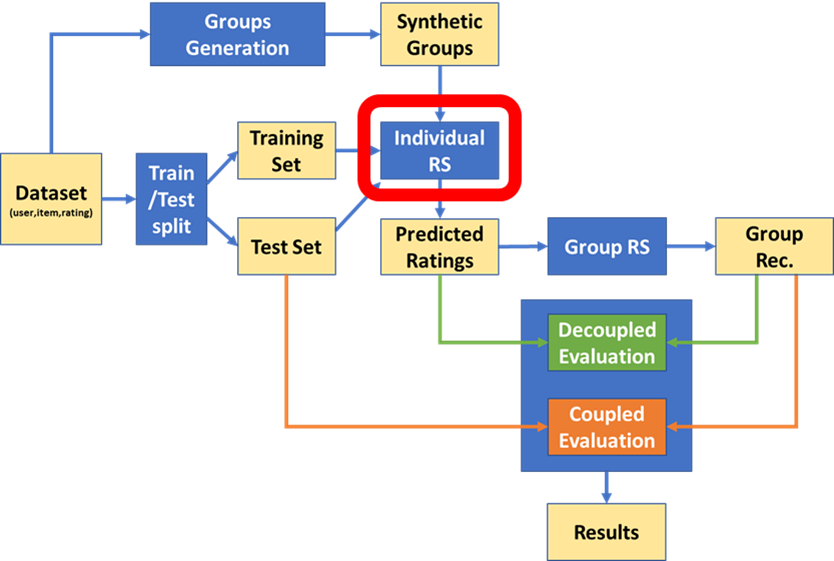

- Which strategy to use?
- Which WineIDs we consider for computing the predicted ratings?


In [308]:
train_df = train_df.rename(columns={
    'RatingID': 'ratingId',  # Fixed type
    'UserID': 'user',
    'WineID': 'item',
    'Vintage': 'vintage',
    'Rating': 'rating',
    'Date': 'date'
})


In [309]:
#Individual RS

from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser

user_user = UserUser(3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(train_df)
print(recsys)

TopN/UserUser(nnbrs=3, min_sim=0)


In [310]:
# Generate predicted ratings

# test_df['predicted_rating'] = recsys.predict(test_df)
test_WineID = set(test_df["item"].tolist())
test_user = set(test_df["user"].tolist())
test_rating=set(test_df["rating"].tolist())

display(len(test_WineID))
display(len(test_user))
display(len(test_rating))

3673

758

9

In [311]:
extended_test_df = pd.DataFrame({'item': list(test_WineID)}).merge(pd.DataFrame({'user': list(test_user)}), how='cross')
display(extended_test_df)

,item,user
0,155648,1222661
1,155648,1222662
2,155648,1003527
3,155648,1224710
4,155648,1038350
...,...,...
2784129,155647,1007597
2784130,155647,1134582
2784131,155647,1206263
2784132,155647,1169405


In [312]:
extended_test_df['rating'] = recsys.predict(extended_test_df)

display(extended_test_df)

,item,user,rating
0,155648,1222661,5.028825
1,155648,1222662,4.476504
2,155648,1003527,5.157996
3,155648,1224710,4.802139
4,155648,1038350,5.187708
...,...,...,...
2784129,155647,1007597,3.827533
2784130,155647,1134582,3.638238
2784131,155647,1206263,3.329591
2784132,155647,1169405,3.107522


#### 6. Aggregation strategies: generating group recommendations

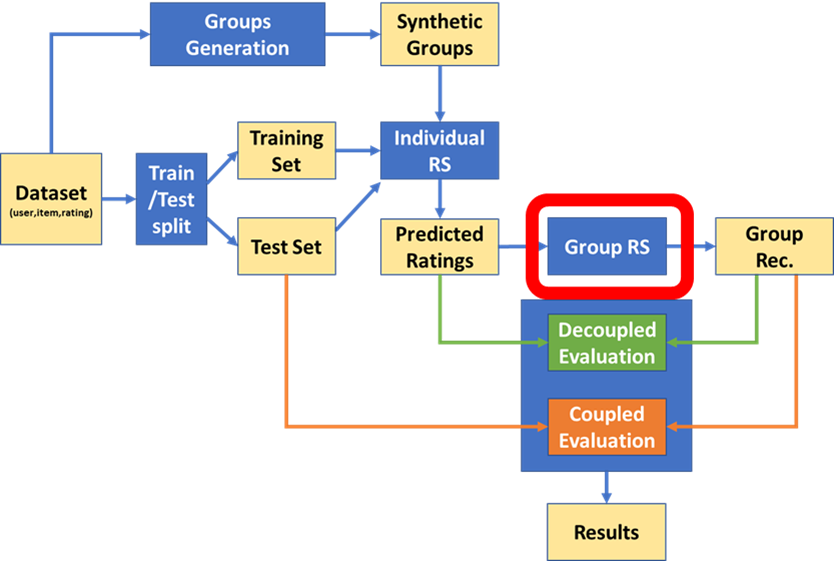


- Which strategies we want to evaluate?

In [313]:
import aggregators as aggr_utils
reload(aggr_utils)
import aggregators as aggr_utils

aggregation_strategies = ["BASE"]
recommendations_number = 10

def generate_group_recommendations_forall_groups(test_df, group_dict, recommendations_number):
    group_recommendations = dict()
    for group_id in group_dict:
        
#         print(datetime.now(), group_id)
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
            
        group_ratings = test_df.loc[test_df['user'].isin(group_members)]
        
        group_rec = dict()
        for aggregation_strategy in aggregation_strategies:
            agg = aggr_utils.AggregationStrategy.getAggregator(aggregation_strategy)
            group_rec = {**group_rec, **agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)}
        
        
        group_recommendations[group_id] = group_rec
        
    return group_recommendations

In [314]:
group_recommendations = generate_group_recommendations_forall_groups(extended_test_df, group_dict, recommendations_number)

display(group_recommendations)

{0: {'ADD': [101744,
   179526,
   111625,
   111430,
   111544,
   101731,
   155312,
   155290,
   111813,
   155648],
  'MUL': [101744,
   179526,
   111625,
   111430,
   111544,
   101731,
   155290,
   155312,
   111813,
   162532],
  'LMS': [111625,
   179526,
   162532,
   111813,
   111391,
   111544,
   111436,
   111583,
   111444,
   179014],
  'MPL': [101744,
   111430,
   155486,
   111520,
   111647,
   111401,
   155312,
   155648,
   162790,
   101731]},
 1: {'ADD': [111412,
   111413,
   111391,
   111403,
   111583,
   111813,
   179014,
   111430,
   111395,
   179369],
  'MUL': [111412,
   111413,
   111391,
   111403,
   111583,
   111813,
   179014,
   111430,
   111395,
   179369],
  'LMS': [111413,
   111412,
   111583,
   111403,
   111391,
   111520,
   111401,
   179530,
   111444,
   135841],
  'MPL': [136428,
   179087,
   155304,
   111849,
   111813,
   111412,
   111436,
   111429,
   111430,
   179014]},
 2: {'ADD': [111647,
   179526,
   111430,
   11

In [324]:
# Visualize the group recommendation
group_recommender_full_dataframe=group_recommendations
wine_df.reset_index(inplace=True)

wine_df= pd.DataFrame(wine_df)
recommendations_df = pd.DataFrame([
    {'strategy': strategy, 'wine_id': wine_id}
    for strategy, wine_ids in group_recommendations.items()
    for wine_id in wine_ids
])
recommendations_list = []
for group_id, strategies in group_recommendations.items():
    for strategy, wine_ids in strategies.items():
        for wine_id in wine_ids:
            recommendations_list.append({'group_id': group_id, 'strategy': strategy, 'wine_id': wine_id})

recommendations_df = pd.DataFrame(recommendations_list)

print(wine_df.columns)
recommendations_df['wine_id'] = recommendations_df['wine_id'].astype(str)
wine_df['WineID'] = wine_df['WineID'].astype(str)  # 确保 WineID 列也是字符串类型
merged_df = recommendations_df.merge(wine_df, left_on='wine_id', right_on='WineID', how='left')
# print("Merged DataFrame:")
# print(merged_df)

# print(merged_df.head(2))

for group_id in merged_df['group_id'].unique():
    group_df = merged_df[merged_df['group_id'] == group_id][['group_id', 'strategy', 'wine_id', 'WineName']]
    print(f"DataFrame for group '{group_id}':")
    print(group_df)
    print("\n")



Index(['index', 'WineID', 'WineName', 'Type', 'Elaborate', 'Grapes',
       'Harmonize', 'ABV', 'Body', 'Acidity', 'Code', 'Country', 'RegionID',
       'RegionName', 'WineryID', 'WineryName', 'Website', 'Vintages'],
      dtype='object')
DataFrame for group '0':
    group_id strategy wine_id                                        WineName
0          0      ADD  101744                                    Vintage Port
1          0      ADD  179526                 Kathryn Hall Cabernet Sauvignon
2          0      ADD  111625                                         Pomerol
3          0      ADD  111430                                         Pomerol
4          0      ADD  111544      Dom Ruinart Blanc de Blancs Brut Champagne
5          0      ADD  101731                          Reserva Especial Douro
6          0      ADD  155312                                           Unico
7          0      ADD  155290                                     Valbuena 5º
8          0      ADD  111813     

#### 7. Evaluation

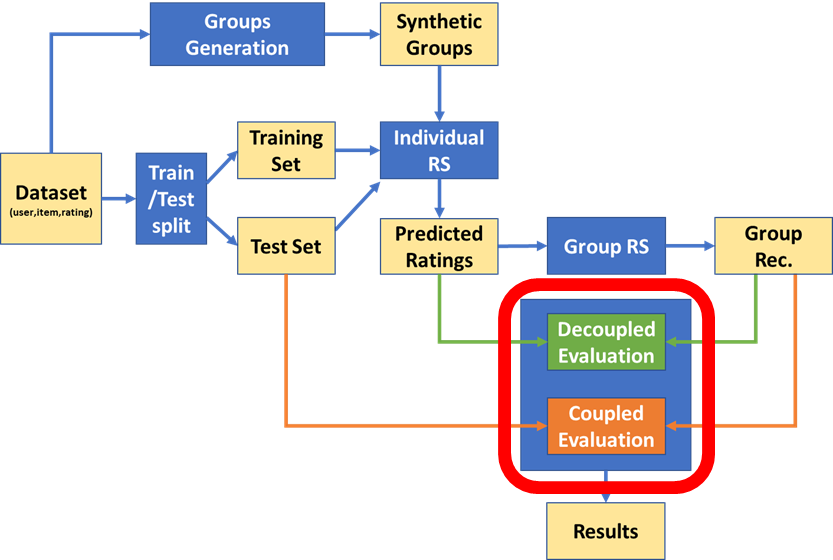

- Coupled or Decoupled?
- Metric? How we aggregate metrics for group members?

#### 7.1 NDCG metric

- We see an implementation of the NDCG metric.


In [316]:
def evaluateUserNDCG(user_ground_truth, group_recommendation):
    dcg = 0

    for k, item in enumerate(group_recommendation):
        dcg = dcg + ((user_ground_truth.loc[item, "final_rating"] if item in user_ground_truth.index else 0) / np.log2(k + 2)) # +2? CHeck with the course slides

    idcg = 0
    user_ground_truth.sort_values("final_rating", inplace=True, ascending=False)
    for k in range(min(len(user_ground_truth), len(group_recommendation))):
        idcg = idcg + (user_ground_truth.iloc[k]["final_rating"] / np.log2(k + 2)) # +2? CHeck with the course slides
    if idcg > 0:
        ndcg = dcg / idcg
    else:
        ndcg = 0

    return ndcg


#### 7.2 Aggregating metric for group members

- We report results aggregating using: mean, min, minmax.

In [317]:
def evaluateGroupRecommendation(group_ground_truth, group_recommendation, group_members):
    ndcg_list = list()
    dcg_list = list()
    binarize_feedback=False
    binarize_feedback_positive_threshold=10
    for user in group_members:
        
        user_ground_truth = group_ground_truth.loc[group_ground_truth['user'] == user]
        user_ground_truth.set_index("item", inplace=True)

        # feedback binarization
        if binarize_feedback == True:
            user_ground_truth["final_rating"] = 0
            user_ground_truth.loc[user_ground_truth.rating >= binarize_feedback_positive_threshold,"final_rating"] = 1         
        # no modifications to feedback
        else:
            user_ground_truth["final_rating"] = user_ground_truth["rating"]
        
        ndcg_user = evaluateUserNDCG(user_ground_truth, group_recommendation)
        ndcg_list.append(ndcg_user)

        # failsafe for all negative results
        if np.amax(ndcg_list) > 0:
            ndcg_min_max = np.amin(ndcg_list) / np.amax(ndcg_list)
        else:
            ndcg_min_max = 0.0
            dcg_min_max = 0.0
    return [
        {
            "metric": "NDCG",
            "aggr_metric": "mean",
            "value": np.mean(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "min",
            "value": np.amin(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "minmax",
            "value": ndcg_min_max
        }
    ]



#### 7.3 Evaluating recommendations for all the groups

In [318]:
def evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict):
                                                 
    group_evaluations = list()
    for group_id in group_dict:
        
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
        group_rec = group_recommendations[group_id]
            
        # filter ratings in ground_truth for the group members
        group_ground_truth = ground_truth.loc[ground_truth['user'].isin(group_members)]
        

        for aggregation_strategy in group_rec:
            agg_group_rec = group_rec[aggregation_strategy]
            agg_group_rec_eval = evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)
    
            # Adding aggregation strategy info
            for row in agg_group_rec_eval:
                row['aggregation_strategy'] = aggregation_strategy
                row['group_id'] = group_id

            group_evaluations = group_evaluations + agg_group_rec_eval
        
    return group_evaluations    

In [319]:
print(extended_test_df.columns)


Index(['item', 'user', 'rating'], dtype='object')


In [320]:

test_df=test_df.drop(columns=['rating'])
display(test_df.head(5))
print(test_df_drop_rating.columns)

,ratingId,user,item
1007835,1007836,1367299,135838
5204669,5204670,1008661,136301
2343225,2343226,1084059,100029
6045022,6045023,1212264,179035
15449234,15449235,1735467,179565


Index(['ratingId', 'user', 'item'], dtype='object')


In [321]:
# Reorder columns by specifying the desired order
train_df = train_df[['item', 'user', 'rating']]

# Verify the new column order
print(train_df.columns)


Index(['item', 'user', 'rating'], dtype='object')


#### 7.4 Decoupled Evaluation

- In this case the ground truth are the predicted ratings

In [322]:
import warnings
warnings.filterwarnings('ignore')

ground_truth = extended_test_df
print(ground_truth)
decoupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(decoupled_results)


           item     user    rating
0        155648  1222661  5.028825
1        155648  1222662  4.476504
2        155648  1003527  5.157996
3        155648  1224710  4.802139
4        155648  1038350  5.187708
...         ...      ...       ...
2784129  155647  1007597  3.827533
2784130  155647  1134582  3.638238
2784131  155647  1206263  3.329591
2784132  155647  1169405  3.107522
2784133  155647  1193982  3.133475

[2784134 rows x 3 columns]


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9844899223974214,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9777542674220442,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9864094407385455,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9845639628426146,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9801327253449602,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9910389100045587,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9716818040941323,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9537060059467192,
  'aggregation_strategy': 'LMS',
 

In [323]:
ground_truth['rating'] = recsys.predict(ground_truth)
display(ground_truth.head(3))
coupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(coupled_results)


,item,user,rating
0,155648,1222661,5.028825
1,155648,1222662,4.476504
2,155648,1003527,5.157996


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9844899223974214,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9777542674220442,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9864094407385455,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9845639628426146,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9801327253449602,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9910389100045587,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9716818040941323,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9537060059467192,
  'aggregation_strategy': 'LMS',
 